In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('/home/myoui/shared/ML/gene_list_para.csv')

In [3]:
label_encoder = LabelEncoder()
df['gene_type_encoded'] = label_encoder.fit_transform(df['gene_type'])

In [4]:
# Vectorize the 'kmers' feature using CountVectorizer
vectorizer = CountVectorizer()
X_kmers = vectorizer.fit_transform(df['kmers'])
X_kmers_df = pd.DataFrame(X_kmers.toarray(), columns=vectorizer.get_feature_names_out())
X_kmers_df.reset_index(drop=True, inplace=True)

In [5]:
X_numerical = df[['gc_content', 'seq_length', 'mfe', 'dot_count', 'bracket_count']]
X = pd.concat([X_numerical.reset_index(drop=True), X_kmers_df], axis=1)
y = df['gene_type_encoded']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Convert y_train and y_test to numpy arrays
y_train = y_train.values
y_test = y_test.values

In [9]:
class GeneDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader instances with the standardized data
train_dataset = GeneDataset(X_train, y_train)
test_dataset = GeneDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, embed_size, num_classes, num_heads, num_layers, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_size, embed_size)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embed_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, num_classes)
        
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  
        x = self.transformer_encoder(x)
        x = x[:, 0, :]  
        x = self.fc(x)
        return x

# Parameters
input_size = X_train.shape[1]
embed_size = 64
num_classes = len(set(y))
num_heads = 4
num_layers = 2

# Instantiate and send model to device
model = TransformerClassifier(input_size=input_size, embed_size=embed_size, num_classes=num_classes,
                              num_heads=num_heads, num_layers=num_layers, dropout=0.1).to(device)


In [11]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

# Start training
train_model(model, train_loader, criterion, optimizer)

Epoch 1/20, Loss: 0.4398
Epoch 2/20, Loss: 0.1633
Epoch 3/20, Loss: 0.1065
Epoch 4/20, Loss: 0.0881
Epoch 5/20, Loss: 0.0529
Epoch 6/20, Loss: 0.0376
Epoch 7/20, Loss: 0.0403
Epoch 8/20, Loss: 0.0453
Epoch 9/20, Loss: 0.0376
Epoch 10/20, Loss: 0.0304
Epoch 11/20, Loss: 0.0236
Epoch 12/20, Loss: 0.0131
Epoch 13/20, Loss: 0.0077
Epoch 14/20, Loss: 0.0158
Epoch 15/20, Loss: 0.0402
Epoch 16/20, Loss: 0.0235
Epoch 17/20, Loss: 0.0196
Epoch 18/20, Loss: 0.0116
Epoch 19/20, Loss: 0.0098
Epoch 20/20, Loss: 0.0292


              precision    recall  f1-score   support

      lncRNA       0.98      0.98      0.98       418
       miRNA       0.85      0.86      0.86       388
    misc_RNA       0.98      0.90      0.94       479
       snRNA       0.98      0.97      0.97       376
      snoRNA       0.72      0.86      0.79       198

    accuracy                           0.92      1859
   macro avg       0.90      0.91      0.91      1859
weighted avg       0.93      0.92      0.92      1859



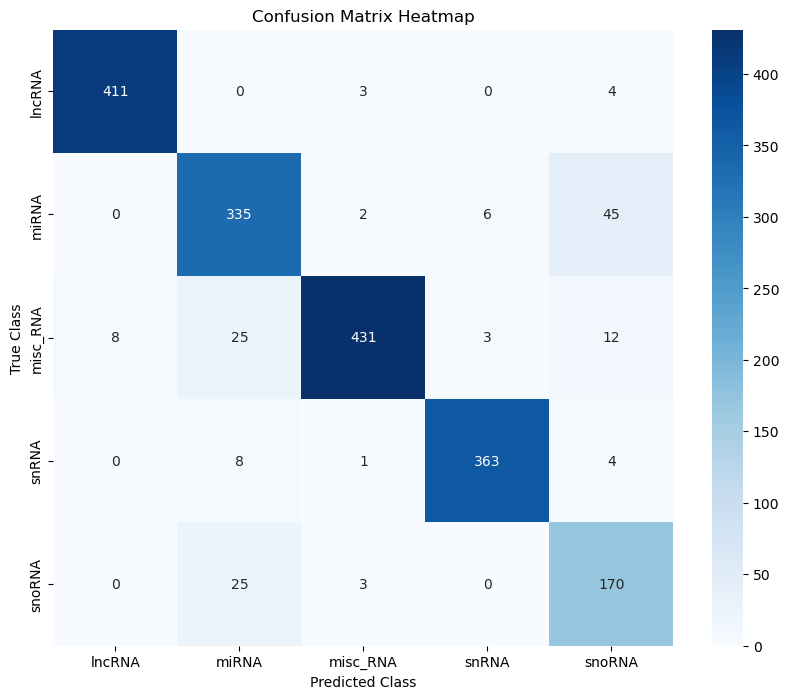

In [13]:
def evaluate_model_with_classification_report(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Classification report
    print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

# Evaluate the model
evaluate_model_with_classification_report(model, test_loader)